# PRICING AND HEDGING - Lista 2

Exercício 1:

Usando o construtor de portfolios hedgeados e simulação de Monte Carlo que vocês ou já tem ou vão poder
copiar/adaptar de https://github.com/MarcosCarreira/DermanPapers e o paper do Wilmott, simulem o tipo de
resultado que ele obteve:

Output desejado:
Os dois gráficos de P&L no tempo para os casos de hedge com vol real e vol implícita (páginas 24 e 31)
Distribuição do P&L final e comparação com resultados teóricos (páginas 21 e 29 e paper do Derman)
Podem usar r=q=0 e K=S0
Para o gráfico 20 trilhas servem
Para a distribuição umas 500.
Dica: Usem como inputs volpricing=implícita e voldelta=implícita ou real
O Monte Carlo usa a vol real.

## Preparing methods

In [15]:
from __future__ import division

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st

%matplotlib inline

Allocates an empty array and fills it with x:

In [16]:
def ca(x, size):
    y = np.empty(size)
    y.fill(x)
    return y

Includes de value zero in the first position:

In [17]:
def ppzero(s):
    return pd.Series(pd.Series.append(pd.Series([0]), s).values)

Generates the Monte Carlo path:

In [18]:
def mcpath(nsteps, S0, drift, vol, t):
    # Generates nsteps random numbers N(0, 1)
    nmdr = pd.Series(np.random.standard_normal(nsteps))
    # Time discretization
    dt = t/nsteps
    # Create an array of dt
    ts = pd.Series(ca(dt, nsteps))
    # Include initial t0
    ts0 = ppzero(ts)
    s1 = (drift - pow(vol, 2)/2) * dt
    s2 = vol * np.sqrt(dt)
    # Steps = Sum of two vectors
    steps = s1 * pd.Series(ca(1, nsteps)) + s2 * nmdr
    steps0 = ppzero(steps)
    # Accumulate
    cmsteps = steps0.cumsum()
    cmts = ts0.cumsum()
    # Convert steps to path
    Sj = S0 * np.exp( cmsteps.values )
    # create timeseries [t,St]
    path=pd.Series(Sj, index=cmts.values)
    
    return path

Monte Carlo paths generator:

In [19]:
def mcpaths(npaths, nsteps, S0, drift, vol, t):
    # generate npaths using mcpath
    paths=[mcpath(nsteps, S0, drift, vol, t) for j in range(npaths)]
    return paths

Defining the Black&Scholes function:

In [20]:
def bsv(phi, S, K, r, q, volpricing, voldelta, t):
    if (t > 0):
        fwd=S*np.exp((r-q)*t)
        efv=t*(volpricing**2)
        # calculate d1 and d2
        d1=(np.log(fwd/K)+(efv/2))/(np.sqrt(efv))
        d2=(np.log(fwd/K)-(efv/2))/(np.sqrt(efv))
        # calculate N(d1) and N(d2)
        Nd1=st.norm.cdf(phi*d1)
        Nd2=st.norm.cdf(phi*d2)
        
        # calculate premium
        pr=phi*S*np.exp(-q*t)*Nd1-phi*K*np.exp(-r*t)*Nd2
        
        # calculate delta
        efvDelta=t*(voldelta**2)
        d1Delta=(np.log(fwd/K)+(efvDelta/2))/(np.sqrt(efvDelta))
        Nd1Delta=st.norm.cdf(phi*d1Delta)
        de=phi*np.exp(-q*t)*Nd1Delta
    else:
        de = 0
        if (phi == 1):
            pr = max(S-K, 0)
        else:
            pr = max(K-S, 0)
        
    return [pr, de]

Adds [premium, delta] to [time, spot]:

In [21]:
def calcpath(path, phi, K ,r, q, volpricing, voldelta, T):
    ttm=T-path.index
    bsvpath=np.array([[path.index[j], path.values[j]] + bsv(phi, path.values[j], K, r, q, volpricing, voldelta, ttm[j])\
                      for j in range(len(path))])

    return pd.DataFrame(bsvpath,columns=['time','spot','premium','delta'])

Calculate P&L and cashflow of portfolio\
Fill dataframe\
time, spot, premium, delta, cfwprem, timechg, dltchg, spotchg, cfwspot, cfwprer, balance, portf

In [22]:
def filldf(path, phi, K, r, q, volpricing, voldelta, T):
    nstp=len(path)-1
    # calculate t,S(t),premium(t),delta(t)
    df=calcpath(path, phi, K, r, q, volpricing, voldelta, T)
    # cashflows for the option
    df['cfwprem']=0
    df.loc[0,'cfwprem']=-df['premium'][0]
    df.loc[nstp,'cfwprem']=df['premium'][nstp]
    df.loc[nstp,'premium']=0
    # calculate time intervals dt
    df['timechg']=df['time'].diff()
    df.loc[0,'timechg']=0
    # calculate changes in delta
    df.loc[nstp,'delta']=0
    df['dltchg']=df['delta'].diff()
    df.loc[0,'dltchg']=0
    # calculate changes in spot price
    df['spotchg']=df['spot'].diff()
    df.loc[0,'spotchg']=0
    # cashflows for the asset
    df['cfwspot']=0
    df.loc[0,'cfwspot']=df['delta'][0]*df['spot'][0]
    df.loc[1:,'cfwspot']=df['dltchg'][1:]*df['spot'][1:]
    # dividend cashflows
    df['cfwdivid']=0
    df.loc[1:,'cfwdivid']=-((df['delta'][0:nstp]*df['spot'][0:nstp]).values)*(np.exp(q*df['timechg'][1:].values)-1)
    # cashflows before interest
    df['cfwprer']=df['cfwprem']+df['cfwspot']+df['cfwdivid']
    # interest and consolidation of cashflows
    df['balance']=0
    df.loc[0,'balance']=df['cfwprer'][0]
    for j in range(1,nstp+1):
        df.loc[j,'balance']=df['balance'][j-1]*(np.exp(r*df['timechg'][j]))+df['cfwprer'][j]
    # portfolio
    df['portf']=df['premium']-df['delta']*df['spot']+df['balance']
    # consolidated discount factor
    return df

Gets only portfolio values:

In [23]:
def portfolio(path, phi, K, r, q, volpricing, voldelta, T):
    fulldf=filldf(path, phi, K, r, q, volpricing, voldelta, T)
    return pd.Series(fulldf['portf'].values)

Gets final value of portfolio:

In [24]:
def finalpl(path, phi, K, r, q, volpricing, voldelta, T):
    portf=portfolio(path, phi, K, r, q, volpricing, voldelta, T)
    return portf[len(path)-1]

Returns final PnL for each path:

In [25]:
def finalplpaths(paths, phi, K, r, q, volpricing, voldelta, T):
    pls=np.array([finalpl(path, phi, K, r, q, volpricing, voldelta, T) for path in paths])
    return pd.Series(pls)

Calculates portfolio over time given path\
return portfolio through time

In [26]:
def portfolioOverTime(path, phi ,K, r, q, volpricing, voldelta, T):
    fulldf = filldf(path, phi, K, r, q, volpricing, voldelta, T)
    return pd.Series(fulldf['portf'].values, index=fulldf['time'].values)

Calculates portfolios over time given paths:

In [27]:
def portfoliosOverTime(paths, phi, K, r, q, volpricing, voldelta, T):
    portfoliosPaths=pd.DataFrame([portfolioOverTime(path, phi, K, r, q, volpricing, voldelta, T) for path in paths])
    return portfoliosPaths

## Running the exercise

Inputs:

In [28]:
call = 1
put = -1
S0 = 100
K = 100
actualVol = 0.30
impliedVol = 0.20
T = 1
q = 0
r = 0
numPaths = 20
numSteps = 500
phi = call

Simulate stock paths with Monte Carlo:

In [29]:
allpaths=mcpaths(numPaths, numSteps, S0, r-q, actualVol, T)

### Hedging with actual volatility:

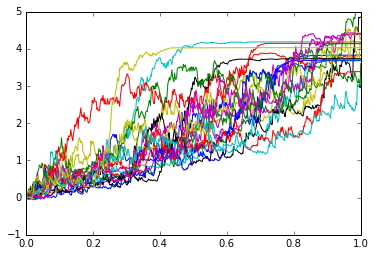

In [30]:
pnlOverTimeActualVol=portfoliosOverTime(allpaths, phi, K ,r, q, impliedVol, actualVol, T)
pnlOverTimeActualVol.transpose().plot(legend=False)

### Hedging with implied volatility:

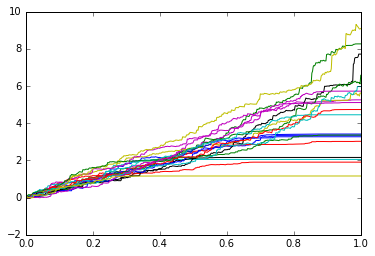

In [31]:
pnlOverTimeImpliedVol=portfoliosOverTime(allpaths, phi, K ,r, q, impliedVol, impliedVol, T)
pnlOverTimeImpliedVol.transpose().plot(legend=False)

Final PnL with actual volatility:

In [32]:
pnlActualVol = finalplpaths(allpaths, phi, K, r, q, impliedVol, actualVol, T)

Final PnL with implied volatility:

In [33]:
pnlImpliedVol = finalplpaths(allpaths, phi, K, r, q, impliedVol, impliedVol, T)

Call premium:

In [37]:
callpr=bsv(phi, S0, K, r, q, impliedVol, impliedVol, T)[0]

### Pnl distribuition comparison:

In [36]:
mPnlActualVol = pnlActualVol.mean()
mPnlImpliedVol = pnlImpliedVol.mean()
stdPnlActualVol = pnlActualVol.std()
stdPnlImpliedVol = pnlImpliedVol.std()
statsActualVol = np.array([mPnlActualVol, stdPnlActualVol, 100 * stdPnlActualVol/callpr])
statsImpliedVol = np.array([mPnlImpliedVol, stdPnlImpliedVol, 100 * stdPnlImpliedVol/callpr])
dfsumm = pd.DataFrame([statsActualVol, statsImpliedVol],index=['Actual vol', 'Implied Vol'],\
                    columns=['Mean P&L', 'Standard Dev. of P&L', 'StDev of P&L as a % of option \
premium'])
dfsumm.index.name='Hedging type'
dfsumm

,Mean P&L,Standard Dev. of P&L,StDev of P&L as a % of option premium
Hedging type,,,
Actual vol,4.027374,0.472171,5.927652
Implied Vol,4.611328,2.204717,27.678094
